## Prediction model

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import torch.nn.functional as F

n_component=14

class FNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_component,128)
        self.fc2 = nn.Linear(128, 512)
        self.dp1 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(512, 256)
        self.dp2 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 1)
        
    def forward(self, x):
        h = F.selu(self.fc1(x)) #best: selu, leaky_relu
        h = F.selu(self.fc2(h))
        h = self.dp1(h)
        h = F.selu(self.fc3(h))
        h = self.dp2(h)
        h = F.selu(self.fc4(h))
        h = F.selu(self.fc5(h))
        h = F.selu(self.fc6(h))
        h = F.selu(self.fc7(h))
        out = self.fc8(h)
        return out

    def fit(self, data_loader, criterion, optimizer):
        self.train()
        sum_train_losses = 0

        for data, target in data_loader:
            
            optimizer.zero_grad()
            pred = self(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            sum_train_losses += loss.item()

        return sum_train_losses / len(data_loader)

    def predict(self, data_loader):
        self.eval()
        list_preds = list()

        with torch.no_grad():
            for data, _ in data_loader:
                pred = self(data)
                list_preds.append(pred)

        return torch.cat(list_preds, dim=0).cpu().numpy()

class FNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_component,128)
        self.fc2 = nn.Linear(128, 256)
        self.dp1 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 128)
        self.fc5 = nn.Linear(128, 1)
        
    def forward(self, x):
        h = F.selu(self.fc1(x)) #best: selu, leaky_relu
        h = F.selu(self.fc2(h))
        h = self.dp1(h)
        h = F.selu(self.fc3(h))
        h = F.selu(self.fc4(h))
        out = self.fc5(h)
        return out
    
    def fit(self, data_loader, criterion, optimizer):
        self.train()
        sum_train_losses = 0

        for data, target in data_loader:
            
            optimizer.zero_grad()
            pred = self(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            sum_train_losses += loss.item()

        return sum_train_losses / len(data_loader)

    def predict(self, data_loader):
        self.eval()
        list_preds = list()

        with torch.no_grad():
            for data, _ in data_loader:
                pred = self(data)
                list_preds.append(pred)

        return torch.cat(list_preds, dim=0).cpu().numpy()

In [2]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('split/train_split.csv')
df = df.drop(labels=['compound_name'],axis = 1)
df.columns.values

array(['l', 'b1', 'b5', 'l_2', 'b1_2', 'b5_2', 'cfbr3', 'phosphorus',
       'c13', 'solvent', 'temp', 'time_min', 'e_y', 'z_y'], dtype=object)

In [4]:
from ctgan import CTGAN
discrete_columns = ['cfbr3', 'phosphorus','solvent', 'temp']

In [5]:
ctgan = CTGAN(epochs=50)
ctgan.fit(df, discrete_columns)
synthetic_data = ctgan.sample(40)

In [6]:
df.insert(0,'real_rational',1)
df.insert(0,'is_synthetic',0)
synthetic_data.insert(0,'real_rational',0)
synthetic_data.insert(0,'is_synthetic',1)

In [7]:
train_set = pd.read_csv('split/train_split_aug_2nd.csv')
train_set = train_set.drop(labels=['compound name'],axis = 1)
train_set.insert(0,'is_synthetic',0)

In [8]:
train_set = pd.concat([train_set,synthetic_data], ignore_index=True)

In [9]:
test_set = pd.read_csv('split/test_split_aug.csv')
test_set.insert(0,'is_synthetic',0)

train_set = np.delete(train_set, [], 1).astype(float)
test_set = np.delete(test_set, [2], 1).astype(float)

nFeat = len(train_set[0,:]) - 2

X_train = train_set[:,:nFeat]
X_test = test_set[:,:nFeat]
Y_train_1 = train_set[:,nFeat:nFeat+1]
Y_test_1 = test_set[:,nFeat:nFeat+1]
Y_train_2 = train_set[:,nFeat+1:nFeat+2]
Y_test_2 = test_set[:,nFeat+1:nFeat+2]

In [10]:
#scaler, w/o time
scalerx = RobustScaler().fit (X_train)
X_train = scalerx.transform(X_train)
X_test  = scalerx.transform(X_test)

model: FNN
R2 score:     0.84		0.9


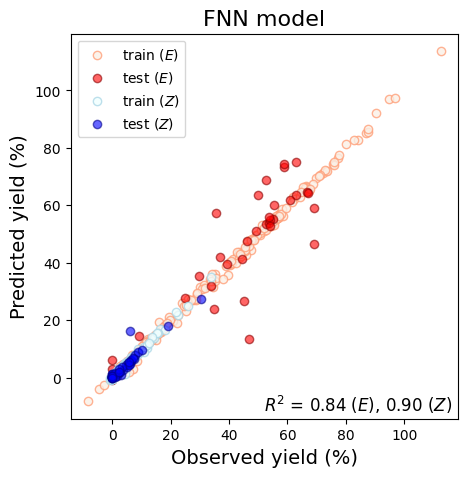

In [15]:
model_1 = {}
model_2 = {}

model_1 = FNN1()
model_2 = FNN2()

print('model: FNN')

random_seed = 5
X_train_1, X_val_1, Y_train_1i, Y_val_1 = train_test_split(X_train, Y_train_1, test_size=0.22, shuffle=True, random_state=random_seed)
X_train_2, X_val_2, Y_train_2i, Y_val_2 = train_test_split(X_train, Y_train_2, test_size=0.22, shuffle=True, random_state=random_seed)

X_train_1t = torch.Tensor(X_train_1)
X_val_1t = torch.Tensor(X_val_1)
X_test_1t = torch.Tensor(X_test)
Y_train_1t = torch.Tensor(Y_train_1i)
Y_val_1t = torch.Tensor(Y_val_1)
Y_test_1t = torch.Tensor(Y_test_1)
X_train_2t = torch.Tensor(X_train_2)
X_val_2t = torch.Tensor(X_val_2)
X_test_2t = torch.Tensor(X_test)
Y_train_2t = torch.Tensor(Y_train_2i)
Y_val_2t = torch.Tensor(Y_val_2)
Y_test_2t = torch.Tensor(Y_test_2)

data_train_1 = TensorDataset(X_train_1t, Y_train_1t)
data_val_1 = TensorDataset(X_val_1t, Y_val_1t)
data_test_1 = TensorDataset(X_test_1t, Y_test_1t)
train_loader_1 = DataLoader(data_train_1, batch_size=64, shuffle=False)
val_loader_1 = DataLoader(data_val_1, batch_size=64, shuffle=False)
test_loader_1 = DataLoader(data_test_1, batch_size=64, shuffle=False)
data_train_2 = TensorDataset(X_train_2t, Y_train_2t)
data_val_2 = TensorDataset(X_val_2t, Y_val_2t)
data_test_2 = TensorDataset(X_test_2t, Y_test_2t)
train_loader_2 = DataLoader(data_train_2, batch_size=64, shuffle=False)
val_loader_2 = DataLoader(data_val_2, batch_size=64, shuffle=False)
test_loader_2 = DataLoader(data_test_2, batch_size=64, shuffle=False)

criterion = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters())
optimizer_2 = optim.Adam(model_2.parameters())

for epoch in range(1000):
    model_1.train()
    train_loss_1 = model_1.fit(train_loader_1, criterion, optimizer_1)
    model_1.eval()
    val_loss_1 = model_1.fit(val_loader_1, criterion, optimizer_1)
for epoch in range(1000):
    model_2.train()
    train_loss_2 = model_2.fit(train_loader_2, criterion, optimizer_2)
    model_1.eval()
    val_loss_2 = model_2.fit(val_loader_2, criterion, optimizer_2)
    
Y_pred_1 = model_1.predict(test_loader_1)
Y_test_1t = Y_test_1t.detach().numpy()
Y_train_out_1 = model_1.predict(train_loader_1)
Y_train_1t = Y_train_1t.detach().numpy()
Y_val_out_1 = model_1.predict(val_loader_1)
Y_val_1t = Y_val_1t.detach().numpy()
r2_yield1 = np.around(r2_score(Y_test_1t,Y_pred_1), 2)
Y_pred_2 = model_2.predict(test_loader_2)
Y_test_2t = Y_test_2t.detach().numpy()
Y_train_out_2 = model_2.predict(train_loader_2)
Y_train_2t = Y_train_2t.detach().numpy()
Y_val_out_2 = model_2.predict(val_loader_2)
Y_val_2t = Y_val_2t.detach().numpy()
r2_yield2 = np.around(r2_score(Y_test_2t,Y_pred_2), 2)

print('R2 score:     {}\t\t{}'.format(r2_yield1, r2_yield2))

plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(Y_train_1t, Y_train_out_1, edgecolors='lightsalmon', facecolors='linen', alpha=0.8, label='train ($\it{E}$)')
plt.scatter(Y_val_1t, Y_val_out_1, edgecolors='lightsalmon', facecolors='linen', alpha=0.8)
plt.scatter(Y_test_1t, Y_pred_1, edgecolors='darkred', facecolors='red', alpha=0.6, label='test ($\it{E}$)')
plt.scatter(Y_train_2t, Y_train_out_2, edgecolors='lightblue', facecolors='azure', alpha=0.8, label='train ($\it{Z}$)')
plt.scatter(Y_val_2t, Y_val_out_2, edgecolors='lightblue', facecolors='azure', alpha=0.8)
plt.scatter(Y_test_2t, Y_pred_2, edgecolors='darkblue', facecolors='blue', alpha=0.6, label='test ($\it{Z}$)')
plt.title('FNN model', fontsize=16)
plt.legend(loc='best')
plt.annotate(r'$R^2$ = {:.2f} '.format(r2_yield1)+'($\mathit{E}$), '+r'{:.2f} '.format(r2_yield2)+'($\mathit{Z}$)', xy=(1,0), xycoords='axes fraction', xytext=(-140, 5), textcoords='offset points', fontsize=12)
plt.xlabel('Observed yield (%)', fontsize=14)
plt.ylabel('Predicted yield (%)', rotation='vertical', fontsize=14)
#plt.show()
plt.savefig('all_aug74+GAN_40_'+str(random_seed)+'.png')
np.savetxt("Y_pred_1t_aug_74+GAN_40_"+str(random_seed)+".csv", Y_pred_1, delimiter=",")
np.savetxt("Y_pred_2t_aug_74+GAN_40_"+str(random_seed)+".csv", Y_pred_2, delimiter=",")
torch.save(model_1,"aug74_gan_40_model_1"+str(random_seed)+".pt")
torch.save(model_2,"aug74_gan_40_model_2"+str(random_seed)+".pt")